# This file contains:
## --implemintation of different loss functions as MAPE, MSE, RMSE, MAE and MSLE for rergression task
## --Also 'BFGS', 'Nelder-Mead', 'Powell', 'CG', 'TNC' numerical optimization funcs used for minimization mentioned loss funcs
# Learning results are collected in the final table 

In [83]:
import numpy as np
from sklearn import datasets

import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
plt.rcParams['figure.figsize'] = [20,8]

## Get data

In [85]:
# Generate nonlinear data with outliers.
# Don't hesitate to change the generation parameters, method and data itself! Observe, how it changes results

n_samples = 1000
n_outliers = 100

X, y, coef = datasets.make_regression(n_samples=n_samples, n_features=1,
                                      n_informative=1, noise=25,
                                      coef=True, random_state=1110)


print(coef)

6.52469309972703


In [86]:
print(X.shape)

(1000, 1)


In [87]:
print(y.shape)

(1000,)


In [88]:
# Replace first N samples with outliers

X[:n_outliers] = np.random.normal(size=(n_outliers, 1))
y[:n_outliers] = 100 * np.random.normal(size=n_outliers)

In [89]:
# Add non-linearity to data

y = y+100*X.T[0]*np.sin(X.T[0])


In [90]:
# Scale data to put in range [0,1] for stability.
# Check results if ignore it.
# See also sklearn User Guide (https://scikit-learn.org/stable/modules/preprocessing.html#scaling-features-to-a-range) and try another tools (Standartization, Normalization)
X = (X - X.min())/(X.max()-X.min())
y = (y - y.min())/(y.max()-y.min())


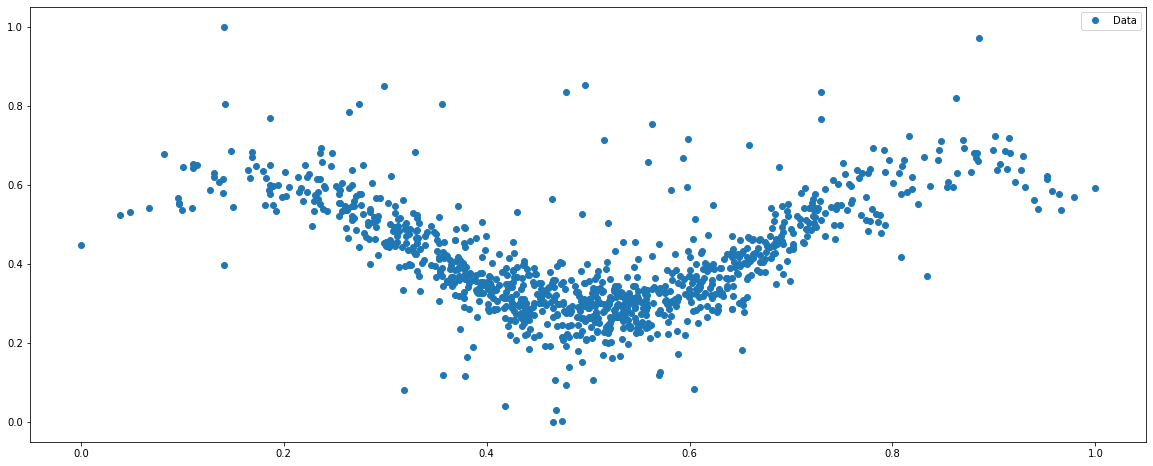

In [91]:
#visualize data
plt.plot(X, y, 'o', label = 'Data')
plt.legend()

In [92]:
# Add bias column to data
X_I = np.c_[np.ones_like(X), X]

## Define Model

### Mean Absolute Percentage Error (MAPE)

Let's use [Mean Absolute Percentage Error](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error) as a custom error function:

$$ \text{MAPE} = \frac{1}{n}\sum_i \left| \frac{y_i - \hat{y_i}}{y_i} \right| \cdot 100\%$$

This function uses percentage ratio between error and original value to express forecast accuracy, which is much more interpretable, than absolute error. 

You can try your loss function here! Figure out something or google anything like 'Best regression loss function'. The only what matters is to take y_true and y_pred on input and return single value.

In [93]:
def mape(y_true, y_pred):
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal"
    
    if np.any(y_true==0):
        #print("Found zeroes in y_true. MAPE is undefined. Removing it from set.")
        idx = np.where(y_true==0)
        y_true = np.delete(y_true, idx)
        y_pred = np.delete(y_pred, idx)
        #print("%i samples deleted" %len(idx))
    
    mape_value = np.mean(np.abs((y_true - y_pred) / y_true))*100
    return mape_value

### Mean squared error (MSE)
[Mean squared error](https://en.wikipedia.org/wiki/Mean_squared_error) as a custom error function:

$$ \text{MSE} = \frac{1}{n}\sum_i  (y_i - \hat{y_i})^2 $$

MSE is scale-dependent. Mathematically, it is the preferred loss function under the inference framework of maximum likelihood if the distribution of the target variable is Gaussian.

In [94]:
def mse(y_true, y_pred):
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal"
    
    mse_value = np.mean(np.power(y_true - y_pred, 2))
    return mse_value

### Root Mean Square Error (RMSE)
[Root Mean Square Error](https://statweb.stanford.edu/~susan/courses/s60/split/node60.html) as a custom error function:

$$ \text{RMSE} = \sqrt{ \frac{1}{n}\sum_i  (y_i - \hat{y_i})^2} $$

RMSE is just the square root of MSE to make it on the same scale as MAE

In [95]:
def rmse(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal"
    rmse_value = np.sqrt(mse(y_true, y_pred))
    return rmse_value

### Mean absolute error (MAE)
[Mean absolute error](https://en.wikipedia.org/wiki/Mean_absolute_error) as a custom error function:

$$ \text{MAE} = \frac{1}{n}\sum_i \left| y_i - \hat{y_i} \right|$$

It measures the average magnitude of errors in a set of predictions, without considering their directions. 

In [96]:
def mae(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal"
    made_value = np.mean(np.abs(y_true - y_pred))
    return made_value

Since MSE squares the error (y — y_predicted = e), the value of error (e) increases a lot if e > 1. If we have an outlier in our data, the value of e will be high and e² will be >> |e|. This will make the model with MSE loss give more weight to outliers than a model with MAE loss. In the 2nd case above, the model with RMSE as loss will be adjusted to minimize that single outlier case at the expense of other common examples, which will reduce its overall performance.

One big problem in using MAE loss (for neural nets especially) is that its gradient is the same throughout, which means the gradient will be large even for small loss values. This isn’t good for learning. To fix this, we can use dynamic learning rate which decreases as we move closer to the minima. MSE behaves nicely in this case and will converge even with a fixed learning rate. The gradient of MSE loss is high for larger loss values and decreases as loss approaches 0, making it more precise at the end of training

### Mean Squared Logarithmic Error (MSLE)
[Mean Squared Logarithmic Error](https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/mean-squared-logarithmic-error-(msle)) as a custom error function:

$$ \text{MSLE} = \frac{1}{n}\sum_i ( log (y_i+1) - log (\hat{y_i}+1) )^2   $$

There may be regression problems in which the target value has a spread of values and when predicting a large value, we may not want to punish a model as heavily as mean squared error. 

As a loss measure, it may be more appropriate when the model is predicting unscaled quantities directly. 

## Mean Squared Logarithmic Error cannot be used when targets contain negative values.

In [97]:
import math
def msle(y_true, y_pred):
    assert len(y_true) == len(y_pred), "Target and Prediction arrays length should be equal"
    y_true =[math.log(i+1) for i in y_true]
    y_pred =[math.log(i+1) for i in y_pred]
    y_true = np.asanyarray(y_true)
    y_pred = np.asanyarray(y_pred)
    msle_value = np.mean(np.power(y_true - y_pred, 2))
    
    return msle_value

### Sklearn impl of mentioned errors

In [98]:
# from sklearn.metrics import mean_absolute_percentage_error
# mean_absolute_percentage_error(y,yy)

In [99]:
import sklearn
sklearn.__version__

'0.22.1'

The function mean_absolute_percentage_error is new in scikit-learn version 0.24 as noted in the documentation.

Our latest version of scikit-learn available from Anaconda is v0.22.1, so that's why you're not able to import mean_absolute_percentage_error.

In [100]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_log_error

#### Aslo for linear regression sklearn uses R^2 cost function which we need to maximize

# Let's calculate mentioned errors of random prediction from target space

In [101]:
y_rand=np.random.random(len(y))

In [102]:
import pandas as pd
erors = {'Custom func Value': [mse(y, y_rand), rmse(y, y_rand), mae(y, y_rand), msle(y, y_rand), '%.2f%%'%mape(y, y_rand)],
         'Sklearn func Value': [mean_squared_error(y, y_rand), '-', mean_absolute_error(y, y_rand), mean_squared_log_error(y, y_rand), '-'],
        'Type': ['absolute error','absolute error','absolute error','absolute error', 'relative error']}

df_erors = pd.DataFrame(erors, columns = ['Custom func Value','Sklearn func Value','Type' ], index=['MSE','RMSE', 'MAE', 'MSLE', 'MAPE'])
print(df_erors)

     Custom func Value Sklearn func Value            Type
MSE           0.119126           0.119126  absolute error
RMSE          0.345146                  -  absolute error
MAE           0.289047           0.289047  absolute error
MSLE         0.0544805          0.0544805  absolute error
MAPE           136.21%                  -  relative error


### Define model

Prediction function $y = \theta^Tx$:

In [103]:
def predict(X, theta):
    return np.dot(X, theta)

# Let's calculate mentioned errors for prediction with random weights(random prediction too)

In [104]:
y_random = predict(X_I, theta = np.random.random(len(X_I[0])))

In [105]:

erors = {'Custom func Value': [mse(y, y_random), rmse(y, y_random) , mae(y, y_random), msle(y, y_random), '%.2f%%'%mape(y, y_random)],
         'Sklearn func Value': [mean_squared_error(y, y_random), '-', mean_absolute_error(y, y_random),mean_squared_log_error(y, y_random),'-'],
        'Type': ['absolute error','absolute error','absolute error','absolute error', 'relative error']}

df_erors = pd.DataFrame(erors, columns = ['Custom func Value','Sklearn func Value','Type' ], index=['MSE','RMSE', 'MAE', 'MSLE', 'MAPE'])
print(df_erors)

     Custom func Value Sklearn func Value            Type
MSE           0.205733           0.205733  absolute error
RMSE          0.453578                  -  absolute error
MAE           0.431817           0.431817  absolute error
MSLE         0.0837084          0.0837084  absolute error
MAPE           182.88%                  -  relative error


# Define objective (goal) function as simple as
$L(\theta|X,y) = MAPE(y, h(\theta|X))$

To make it compatible with optimization procedure, put optimizied parameter _theta_ on the first place in arguments. 

In [106]:
def objective_function(theta, X,y, loss_function=mape):
  y_true = np.asanyarray(y)
  y_pred = predict(X, theta)
  
  return loss_function(y_true, y_pred)

In [107]:
def objective_function_with_regul(theta, X,y, loss_function=mape,lamda = 10):
  y_true = np.asanyarray(y)
  y_pred = predict(X, theta)
  
  return loss_function(y_true, y_pred)+ (lamda / (2*len(y) )) * np.sum(np.square(theta))

# Visualize objective function surface

## MAPE

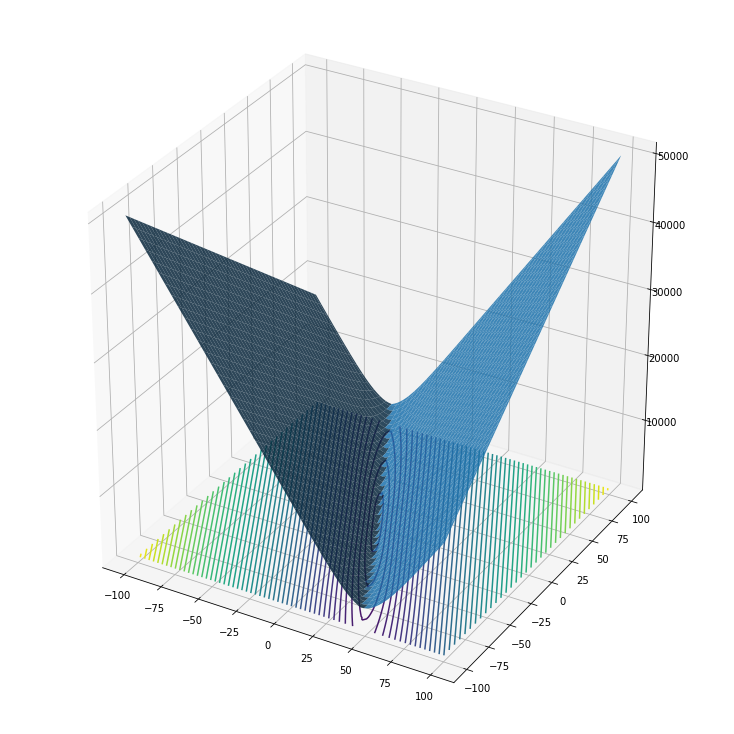

In [108]:
size = 100 # amount of tries for each parameter
limits = (-100,100) # range of values for each parameter
error = np.zeros((size,size)) # empty matrix of errors
for i,w in enumerate(np.linspace(*limits,size)): # for each theta[0] component
    for j,b in enumerate(np.linspace(*limits,size)): # for each theate[1] component
        error[i,j] = objective_function(np.array([b,w]), X_I, y, mape) # compute cost for each theta

# initialize figure
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)

# create 2d array for each index 
K,L = np.meshgrid(np.linspace(*limits,size),np.linspace(*limits,size))

ax.plot_surface(K,L,Z = error, alpha = 0.85) # plot cost function surface in 3d
plt.contour(K,L,error,50, offset = 1) # plot cost function 2d-projection

## RMSE and MAE

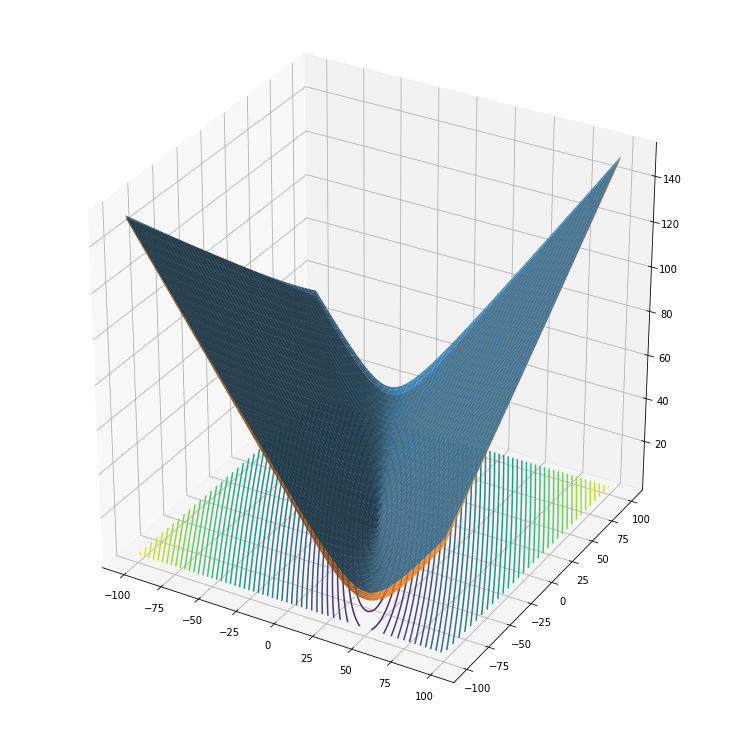

In [109]:
size = 100 # amount of tries for each parameter
limits = (-100,100) # range of values for each parameter
error = np.zeros((size,size)) # empty matrix of errors
error2 = np.zeros((size,size)) # empty matrix of errors
for i,w in enumerate(np.linspace(*limits,size)): # for each theta[0] component
    for j,b in enumerate(np.linspace(*limits,size)): # for each theate[1] component
        error[i,j] = objective_function(np.array([b,w]), X_I, y, rmse) # compute cost for each theta
        error2[i,j] = objective_function(np.array([b,w]), X_I, y, mae) # compute cost for each theta

# initialize figure
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize = (10,10))
ax = Axes3D(fig)

# # create 2d array for each index 
# K,L = np.meshgrid(np.linspace(*limits,size),np.linspace(*limits,size))

ax.plot_surface(K,L,Z = error, alpha = 0.85) # plot cost function surface in 3d
ax.plot_surface(K,L,Z = error2, alpha = 0.85) # plot cost function surface in 3d
plt.contour(K,L,error,50, offset = 1) # plot cost function 2d-projection

We can see that surfaces of RMSE and MAE look similar. It doesn't make any difference which to use for optimization

## Train model

We're done with defining gradient descent step manually!

There are less efficient but more universal approaches, for example use numerical optimization methods. 

Let's try [scipy.optimize](https://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html).

In [110]:
from scipy import optimize

In [111]:
theta_init = np.array([1]*X_I.shape[1]) # initial value of theta

result = optimize.minimize(
                           objective_function,  # function to optimize. Parameter to optimize should the first argument 
                           args=(X_I, y, mape), # other arguments of the function
                           x0 = theta_init,     # initial value of parameter to optimize
                           method='Powell',     # optimization method. Try also BFGS, Nelder-Mead, Powell, CG, TNC and others (see docs). Effectivnes can change dramatically!
                           options={}           # arguments of optimization method, like number of iterations, learning rate, etc.
                           )

In [112]:
print('Optimization result:', ['FAIL','Success'][result.success])
print('Comment:', result.message)
print('Objective function value:', result.fun)
print('Found theta:', result.x)

Optimization result: Success
Comment: Optimization terminated successfully.
Objective function value: 46.72376342350702
Found theta: [0.25751171 0.09930304]


# Powell

In [113]:
loss_funcs =[mse, rmse, mae, mape]
optimized_values = []
optimized_theta = []
for loss in loss_funcs:
    result = optimize.minimize(
                           objective_function,  # function to optimize. Parameter to optimize should the first argument 
                           args=(X_I, y, loss), # other arguments of the function
                           x0 = theta_init,     # initial value of parameter to optimize
                           method='Powell',     # optimization method. Try also BFGS, Nelder-Mead, Powell, CG, TNC and others (see docs). Effectivnes can change dramatically!
                           options={}           # arguments of optimization method, like number of iterations, learning rate, etc.
                           )
    optimized_values.append(result.fun)
    optimized_theta.append(result.x)
    

In [114]:
powell = {'Objective function value': optimized_values,
         'Found theta': optimized_theta}

df_powell = pd.DataFrame(powell, columns = ['Objective function value','Found theta' ], index=['MSE','RMSE', 'MAE', 'MAPE'])
print(df_powell)

      Objective function value                                   Found theta
MSE                   0.019691    [0.3990908287673744, 0.016142182595395984]
RMSE                  0.140324   [0.39908144530343703, 0.016160159330314994]
MAE                   0.111809  [0.38080016618931367, -0.012669289247717281]
MAPE                 46.723763     [0.25751171281760155, 0.0993030353348742]


# BFGS, Nelder-Mead, Powell, CG, TNC methods 

In [115]:
optimized_func = []
optimized_theta = []
methods = []
optimization_methods = ['BFGS', 'Nelder-Mead', 'Powell', 'CG', 'TNC']
loss_f =[]
optimization_result = []
message = []
failed_methods = []
failed_loss = []
failed_message = []
for loss in loss_funcs:
    for method in optimization_methods:
        result = optimize.minimize(
                               objective_function,  # function to optimize. Parameter to optimize should the first argument 
                               args=(X_I, y, loss), # other arguments of the function
                               x0 = theta_init,     # initial value of parameter to optimize
                               method=method,     # optimization method. Try also BFGS, Nelder-Mead, Powell, CG, TNC and others (see docs). Effectivnes can change dramatically!
                               options={}           # arguments of optimization method, like number of iterations, learning rate, etc.
                               )
        loss_f.append(loss.__name__)
        optimization_result.append(['FAIL','Success'][result.success])
        message.append(result.message)
        optimized_func.append(result.fun)
        optimized_theta.append(result.x)
        methods.append(method)
        if result.success == False:
            failed_methods.append(method)
            failed_loss.append(loss.__name__)
            failed_message.append(result.message)
#         print('Optimization method:', '\033[1m'+method+'\033[0m')
#         print('Loss func:', '\033[1m'+str(loss)+'\033[0m')
#         print('Optimization result:', '\033[1m'+'\033[95m'+['FAIL','Success'][result.success]+'\033[0m')
#         print('Comment:', result.message)
#         print('Objective function value:', result.fun)
#         print('Found theta:', result.x)
    

In [116]:
opt_methods = {'Obj func value': optimized_func,
               'Weights': optimized_theta,
        'Result ': optimization_result,
         'Method used': methods}

df_methods = pd.DataFrame(opt_methods, columns = ['Method used','Result ','Obj func value','Weights', 'Method used'], index = loss_f)
print(df_methods)

      Method used  Result   Obj func value  \
mse          BFGS  Success        0.019691   
mse   Nelder-Mead  Success        0.019691   
mse        Powell  Success        0.019691   
mse            CG  Success        0.019691   
mse           TNC  Success        0.019691   
rmse         BFGS  Success        0.140324   
rmse  Nelder-Mead  Success        0.140324   
rmse       Powell  Success        0.140324   
rmse           CG  Success        0.140324   
rmse          TNC  Success        0.140324   
mae          BFGS     FAIL        0.111809   
mae   Nelder-Mead  Success        0.111809   
mae        Powell  Success        0.111809   
mae            CG     FAIL        0.111809   
mae           TNC  Success        0.111809   
mape         BFGS     FAIL       46.723647   
mape  Nelder-Mead  Success       46.723632   
mape       Powell  Success       46.723763   
mape           CG     FAIL       46.723696   
mape          TNC  Success       46.723666   

                                 

## This methods are fail opimization on mae and mape loss function, we can try to tune them or not to use

In [117]:
failed_methods = {'Method used': failed_methods,
        'Loss ': failed_loss,
       'Massage': failed_message}

df_failed_methods = pd.DataFrame(failed_methods, columns = ['Method used','Loss ', 'Massage'])
print(df_failed_methods)


  Method used Loss                                             Massage
0        BFGS   mae  Desired error not necessarily achieved due to ...
1          CG   mae  Desired error not necessarily achieved due to ...
2        BFGS  mape  Desired error not necessarily achieved due to ...
3          CG  mape  Desired error not necessarily achieved due to ...


## By this table we can choose optimization method. Of course for better choose we need to tune each method in particular case with particular loss function and use cross validation to choose the best methods hyper parameters

The most common reason of optimization fail is _'Desired error not necessarily achieved due to precision loss'_. It means, that on some point the procedure became numerically unstable, usually because of too big or too small values of objective function. 

If this point wasn't too close, results are still usable. 

There is also some chance to make result better with changing _theta_init_  or just re-running the function, and, the most reliable, change optimization method's options and method itself.

Also normalizing data is always useful.

# Let's compare some predictions. It unnessesary visualize all because picture will be not informative

In [118]:
result_mape_powell = optimize.minimize( objective_function,  # function to optimize. Parameter to optimize should the first argument 
                               args=(X_I, y, mape), # other arguments of the function
                               x0 = theta_init,     # initial value of parameter to optimize
                               method='Powell',     # optimization method. Try also BFGS, Nelder-Mead, Powell, CG, TNC and others (see docs). Effectivnes can change dramatically!
                               options={}           # arguments of optimization method, like number of iterations, learning rate, etc.
                               )

In [119]:
result_mse_powell = optimize.minimize( objective_function,  # function to optimize. Parameter to optimize should the first argument 
                               args=(X_I, y, mse), # other arguments of the function
                               x0 = theta_init,     # initial value of parameter to optimize
                               method='Powell',     # optimization method. Try also BFGS, Nelder-Mead, Powell, CG, TNC and others (see docs). Effectivnes can change dramatically!
                               options={}           # arguments of optimization method, like number of iterations, learning rate, etc.
                               )

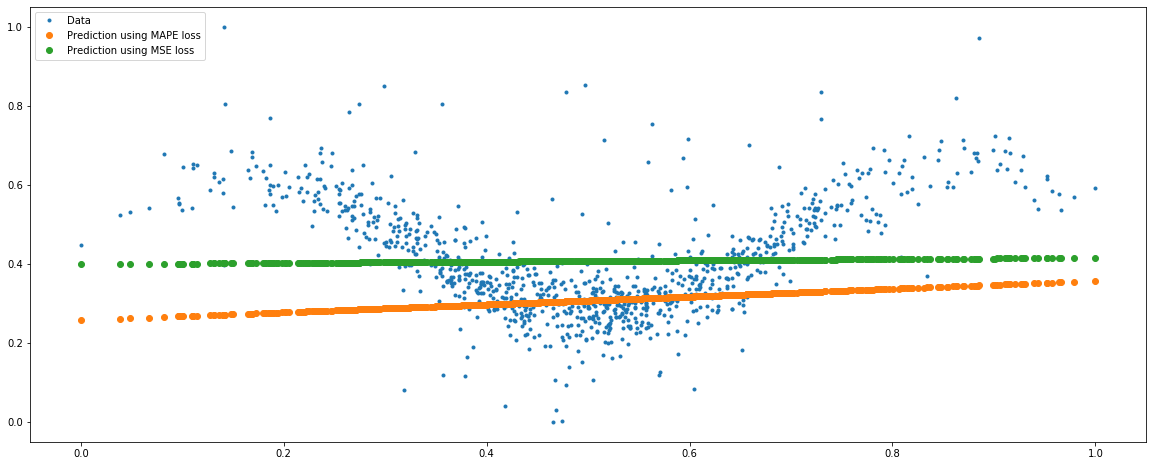

In [120]:
# Visualize result
theta = result.x
y_pred_mape = predict(X_I, result_mape_powell.x)
y_pred_mse = predict(X_I, result_mse_powell.x)
plt.plot(X, y, '.', label = 'Data')
plt.plot(X, y_pred_mape, 'o', label = 'Prediction using MAPE loss')
plt.plot(X, y_pred_mse, 'o', label = 'Prediction using MSE loss')
plt.legend()

## Results look different thats why we need to choose which loss function better fit to our task, goal, data(domain). This influences on our model output params as the result on predictions

# In file HW-2-cross-validation.ipynb we use one pair of loss function and optimizing method with additing polynomial featurs to data for better regression. Polynom degree chossing done by cross-validation